In [1]:
import pandas as pd
import numpy as np
from numpy import asarray

from PIL import Image
from mtcnn.mtcnn import MTCNN

from numpy import load
from numpy import expand_dims
from numpy import savez_compressed
from keras.models import load_model

from tqdm import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## The Main DataFrame:

In [5]:
f1 = pd.read_csv('first_1000_wiki')
f1.fn_embeddings[0]

'[-0.94049406 -0.33341625 -0.9019466  -0.85395443 -0.38657779  1.5694922\n  0.11452714  0.66977364 -0.10230914  0.15784504  1.0248307  -1.2732254\n  0.30466944 -1.082887    0.1619879   0.5970903   0.51482314 -2.0627074\n -1.5192795  -0.14523032  1.7270896  -0.23051898 -0.1617699  -0.27975982\n  1.0542642  -0.07652625  0.6751565   0.4218326   0.29834622  1.4364487\n -1.3355737   0.15867276 -1.9736309  -0.46998864  1.6114961  -0.21380135\n -0.36138523  1.009916    0.37753916 -0.9489006  -0.71557045 -0.39831737\n -1.9096328  -1.0330851  -1.1914957  -2.0593348   1.7300173  -0.3623097\n -0.2033369  -0.8888408  -0.22912903  2.2039454   0.52469486 -0.3154877\n -1.4208626   0.75457376  0.06956541 -1.8759971  -0.35619226  1.2759295\n -0.06153198  0.82792777  0.5392902   0.2275551   1.3570521  -1.0463661\n  0.10053545  2.2402613  -0.2936686   0.11925943  0.54157925  0.77533305\n -1.0586754  -1.5505896   2.1258707   1.3086072   0.27120697  0.86062145\n -1.269005   -1.0778866  -0.7015407  -0.16758

In [9]:
photo_df = pd.read_csv('photo_info_df/All_photo_data.csv')
photo_df.head()

,name,dob,gender,photo_taken,age_when_taken,file_path,face_location,face_score
0,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm124825600_...,[1072.926 161.838 1214.784 303.696],1.459693
1,Fred Astaire,1899-05-10,1.0,1970,71,image_data/imdb_data/01/nm0000001_rm3343756032...,[477.184 100.352 622.592 245.76 ],2.543198
2,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm577153792_...,[114.96964309 114.96964309 451.68657236 451.68...,3.455579
3,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm946909184_...,[622.88550564 424.21750384 844.33900767 645.67...,1.872117
4,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm980463616_...,[1013.85900236 233.88204221 1201.5861278 42...,1.158766


In [10]:
def resize_picture(filename, dimensions = (160,160), margin = 0):
            
    # load the image
    image = Image.open(filename)
    image = image.convert('RGB')
    image_array = asarray(image)
    
    
    #Set a margin boolean and while loop to try margin value
    margin_error = True
    
    while margin_error:
    
        try:
            #Crop the face further with MTCNN
            detector = MTCNN()
    
            #Obtain the first detected face in the cropped face picture
            first_detected_face = detector.detect_faces(image_array)[0]
        
            # get coordinates
            x1, y1, width, height = first_detected_face['box']
            x2, y2 = x1 + width + margin, y1 + height + margin       
            x1 -= margin
            y1 -= margin 
        
            face_array = image_array[y1:y2, x1:x2]
    
        except:
        
            face_array = image_array
        
        try:
            face_array_resized = Image.fromarray(face_array)
            face_array_resized = face_array_resized.resize(dimensions)
            
            margin_error = False
            break
            
        except:
            
            if margin > 0: 
                margin -= 1
            else:
                face_array_resized = Image.fromarray(image_array)
                face_array_resized = face_array_resized.resize(dimensions)
                break
    
    return asarray(face_array_resized)

In [11]:
picture1 = resize_picture(photo_df.file_path[0], dimensions = (160,160), margin = 10)

In [12]:
def plot_face(face_data):
    
    # plot face
    plt.axis('off')
    plt.imshow(face_data)

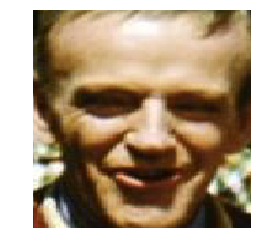

In [13]:
plot_face(picture1)

In [14]:
test = photo_df.copy()

In [ ]:
tqdm.pandas()
test['fn_array'] = test['file_path'].progress_apply(lambda x: resize_picture(x, dimensions = (160,160), margin = 10))


  1%|          | 4170/372917 [1:43:19<153:41:46,  1.50s/it]

### Preparation For The Model

In [ ]:
#The following function is from 'Deep Learning for Computer Vision' by Jason Brownlee, Page (508)

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

### The Model

In [ ]:
# load the FaceNet model
facenet_model = load_model('FaceNet_Model/facenet_keras.h5')
facenet_model.load_weights('FaceNet_Model/facenet_keras_weights.h5')
print(facenet_model.inputs)
print(facenet_model.outputs)

In [ ]:
get_embedding(facenet_model, picture1)